导入所需模块

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

读取数据集，并将数据集合并

In [2]:
ratings = pd.read_csv(
    "../datasets/ml-1m/ratings.dat",
    sep="::",
    names=["userId", "movieId", "rating", "timestamp"],
    engine="python",
)
movies = pd.read_csv(
    "../datasets/ml-1m/movies.dat",
    sep="::",
    names=["movieId", "title", "genres"],
    engine="python",
)
data = ratings.merge(movies, on="movieId")


对数据进行onehot编码

In [3]:
def onehot(df):
    mlb = MultiLabelBinarizer()
    genres_split = df["genres"].str.split("|")
    genres_onehot = mlb.fit_transform(genres_split)
    genres_df = pd.DataFrame(
        genres_onehot,
        columns=[f"genre_{genre}" for genre in mlb.classes_],
        index=df.index,
    )
    return pd.concat([df, genres_df], axis=1)

data = onehot(data)

In [ ]:
def add_unseen_movies_as_negatives(df, movies, n_neg_per_pos=0.2, random_state=42):
    # assume df is for a single user
    user_id = df["userId"].iloc[0]

    # movies this user has already rated
    seen_movie_ids = set(df["movieId"])

    # movies user has not seen
    unseen_movies = movies[~movies["movieId"].isin(seen_movie_ids)].copy()
    if unseen_movies.empty:
        return df

    # how many negatives to add
    n_pos = (df["rating"] != -1).sum()          # only real ratings
    n_neg = min(len(unseen_movies), int(n_neg_per_pos * n_pos))

    # sample which movies we will use as negatives
    neg_samples = unseen_movies.sample(n_neg, random_state=random_state).reset_index(drop=True)

    # timestamp range from this user's real ratings
    valid = df["rating"] != -1
    t_min = df.loc[valid, "timestamp"].min()
    t_max = df.loc[valid, "timestamp"].max()

    # generate unique, ~uniform timestamps in [t_min, t_max]
    if t_max - t_min + 1 >= n_neg:
        # enough integer points → sample without replacement
        ts_candidates = np.arange(t_min, t_max + 1)
        timestamps = np.random.default_rng(random_state).choice(
            ts_candidates, size=n_neg, replace=False
        )
    else:
        # fallback: spread evenly
        timestamps = np.linspace(t_min, t_max, num=n_neg, dtype=int)

    neg_samples["timestamp"] = timestamps
    neg_samples["userId"] = user_id
    neg_samples["rating"] = -1  # placeholder rating for negatives
    neg_samples["genres"] = movies.loc[
        neg_samples.index, "genres"
    ].values  # copy genres from movies df
    neg_samples = onehot(neg_samples)

    return pd.concat([df, neg_samples], ignore_index=True)

user_dfs = {uid: df for uid, df in data.groupby("userId")}
final_data = user_dfs[1]
final_data = add_unseen_movies_as_negatives(final_data, movies, n_neg_per_pos=0.2)

In [31]:
def split_by_timestamp(df, split_ratio=0.8):
    sorted_df = df.sort_values(by="timestamp")
    split_index = int(len(sorted_df) * split_ratio)
    train_df = sorted_df.iloc[:split_index]
    test_df = sorted_df.iloc[split_index:]
    return train_df, test_df

def split_ramdomly(df, split_ratio=0.8, random_state=42):
    train_df = df.sample(frac=split_ratio, random_state=random_state)
    test_df = df.drop(train_df.index)
    return train_df, test_df

train_part, test_part = split_ramdomly(final_data, split_ratio=0.9)

In [32]:
def label_training_data(train_data):
    train_data = train_data.copy()
    valid = train_data["rating"] != -1

    max_rating = train_data.loc[valid, "rating"].max()
    min_rating = train_data.loc[valid, "rating"].min()
    threshold = (max_rating + min_rating) / 2

    train_data["label"] = (train_data["rating"] >= threshold).astype(int)
    return train_data, max_rating, min_rating, threshold

train_data, max_rating, min_rating, threshold = label_training_data(train_part)
print("max:", max_rating, "min:", min_rating, "threshold:", threshold)

max: 5 min: 3 threshold: 4.0


In [33]:
train_feature_cols = (
    [c for c in train_data.columns if  c.startswith("genre_") and not c.endswith("_user")]
)
print(train_feature_cols)
print(train_data.head())
X = train_data[train_feature_cols]
y = train_data["label"]

['genre_Action', 'genre_Adventure', 'genre_Animation', "genre_Children's", 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Fantasy', 'genre_Film-Noir', 'genre_Horror', 'genre_Musical', 'genre_Mystery', 'genre_Romance', 'genre_Sci-Fi', 'genre_Thriller', 'genre_War', 'genre_Western']
    userId  movieId  rating  timestamp                             title  \
19       1     2797       4  978302039                        Big (1988)   
41       1     1961       5  978301590                   Rain Man (1988)   
47       1     1207       4  978300719      To Kill a Mockingbird (1962)   
12       1     2398       4  978302281     Miracle on 34th Street (1947)   
43       1     2692       4  978301570  Run Lola Run (Lola rennt) (1998)   

                  genres  genre_Action  genre_Adventure  genre_Animation  \
19        Comedy|Fantasy             0                0                0   
41                 Drama             0                0                0   
47    

进行单用户决策树的构建，并简单显示参数

In [34]:
clf = DecisionTreeClassifier(
    max_depth=15,
    min_samples_leaf=1,class_weight="balanced"
)

clf.fit(X, y)

,criterion,'gini'
,splitter,'best'
,max_depth,15
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


[10  9 16 17  1  6  2 13  8  5 11  4 14  3  7]


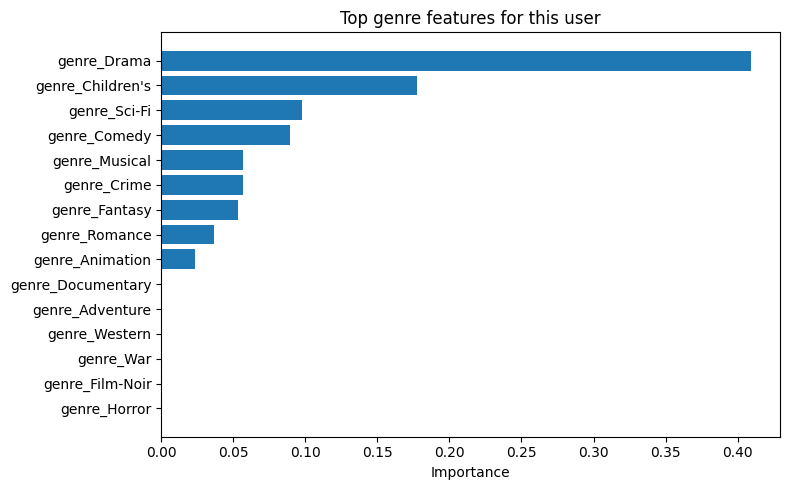

In [35]:
importances = clf.feature_importances_
cols = np.array(train_feature_cols)  # same feature list you used for X

idx = np.argsort(importances)[-15:]  # top 15 features

plt.figure(figsize=(8, 5))
plt.barh(range(len(idx)), importances[idx])
print(idx)
plt.yticks(range(len(idx)), cols[idx])
plt.xlabel("Importance")
plt.title("Top genre features for this user")
plt.tight_layout()
plt.show()


将构建出来的决策树结果打印出来

In [36]:
from sklearn.tree import export_text
print(export_text(clf, feature_names=X.columns.tolist()))

|--- genre_Drama <= 0.50
|   |--- genre_Children's <= 0.50
|   |   |--- genre_Sci-Fi <= 0.50
|   |   |   |--- genre_Fantasy <= 0.50
|   |   |   |   |--- genre_Crime <= 0.50
|   |   |   |   |   |--- genre_Romance <= 0.50
|   |   |   |   |   |   |--- genre_Musical <= 0.50
|   |   |   |   |   |   |   |--- genre_Animation <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- genre_Animation >  0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- genre_Musical >  0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- genre_Romance >  0.50
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- genre_Crime >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- genre_Fantasy >  0.50
|   |   |   |   |--- class: 1
|   |   |--- genre_Sci-Fi >  0.50
|   |   |   |--- genre_Fantasy <= 0.50
|   |   |   |   |--- class: 1
|   |   |   |--- genre_Fantasy >  0.50
|   |   |   |   |--- class: 1
|   |--- genre_Children's >  

In [37]:

def build_features(test, threshold):
    result = test.copy()
    result["label"] = (result["rating"] >= threshold).astype(int)
    return result

test_features = build_features(test_part, threshold=threshold)


对单个用户进行准确度预测

In [38]:
train_feature_cols = (
    [c for c in test_features.columns if  c.startswith("genre_")]
)
print(train_feature_cols)

X = test_features[train_feature_cols]
y = test_features["label"]
clf.score(X, y)

['genre_Action', 'genre_Adventure', 'genre_Animation', "genre_Children's", 'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama', 'genre_Fantasy', 'genre_Film-Noir', 'genre_Horror', 'genre_Musical', 'genre_Mystery', 'genre_Romance', 'genre_Sci-Fi', 'genre_Thriller', 'genre_War', 'genre_Western']


0.8

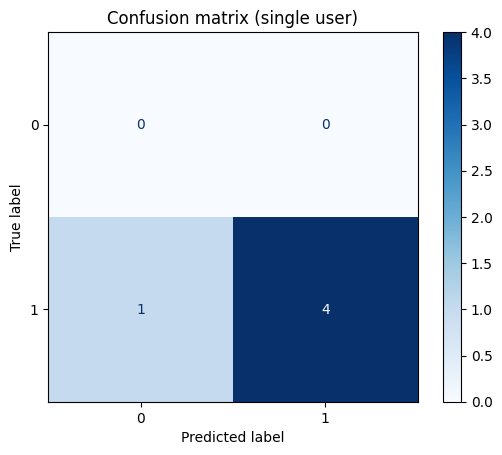

In [39]:
y_pred = clf.predict(X)
cm = confusion_matrix(y, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion matrix (single user)")
plt.show()


对多个用户进行计算预测准确率，如果结果仍较高，证明该方案有效

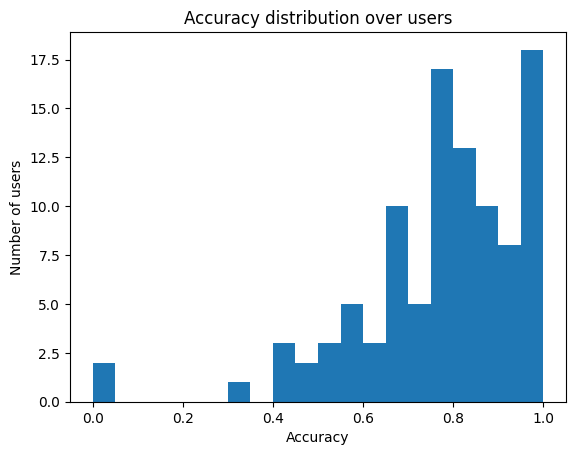

Mean accuracy: 0.7687846219976291


In [40]:
def evolution_scores(user_dfs, n):
    scores = []
    for i in range(1, n + 1):
        final_data = user_dfs[i]
        final_data = add_unseen_movies_as_negatives(final_data, movies, n_neg_per_pos=0.2)
        train_part, test_part = split_ramdomly(final_data, split_ratio=0.9)
        train_data, max_rating, min_rating, threshold = label_training_data(train_part)

        train_feature_cols = [c for c in train_data.columns if c.startswith("genre_")]
        X_train = train_data[train_feature_cols]
        y_train = train_data["label"]

        clf = DecisionTreeClassifier(max_depth=10, min_samples_leaf=1, class_weight="balanced")
        clf.fit(X_train, y_train)

        test_features = build_features(test_part, threshold=threshold)
        test_feature_cols = [c for c in test_features.columns if c.startswith("genre_")]
        X_test = test_features[test_feature_cols]
        y_test = test_features["label"]

        scores.append(clf.score(X_test, y_test))
    return scores


scores = evolution_scores(user_dfs, 100)

plt.hist(scores, bins=20)
plt.xlabel("Accuracy")
plt.ylabel("Number of users")
plt.title("Accuracy distribution over users")
plt.show()

print("Mean accuracy:", np.mean(scores))
